## Power Calculations for A/B testing

In [20]:
from __future__ import division
from math import sqrt 

import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
% matplotlib inline

In [10]:
darr = np.loadtxt('coke_weights.txt')

In [11]:
darr[:3]

array([ 20.02728751,  21.03151282,  20.70545129])

h0 : mean_h0(darr) = 20.4 oz

h1 : mean_h1(darr) != 20.4 oz -->   # mean(darr)

In [26]:
# Sample mean
mean_h1 = darr.mean()

In [27]:
# Sample standard deviation
stdv_h1 = darr.std()

In [203]:
# Sample Standard Error
se = stdv_h1 / float(sqrt(len(darr)))

In [204]:
se, stdv_h1, len(darr)

(0.083994286670484794, 0.95768221510418861, 130)

**Answer:** The sample size is 130, greater than 30. According to the CLT, sampling distribution is approximately normal at the center population mean.

1.96 is the approximate value of the 97.5 percentile point of the normal distribution used in probability and statistics. 95% of the area under a normal curve lies within roughly 1.96 standard deviations of the mean, and due to the central limit theorem, this number is therefore used in the construction of approximate 95% confidence intervals. Its ubiquity is due to the arbitrary but common convention of using confidence intervals with 95% coverage rather than other coverages (such as 90% or 99%). This convention seems particularly common in medical statistics,but is also common in other areas of application, such as earth sciences,social sciences and business research.

In [207]:
def plot_hypothesis_distributions(h_dict, se):
    for m, c in h_dict.iteritems():
        rv = stats.norm(m, scale=se)
        x_range = np.linspace(m - (4*se), m + (4*se), 1000)
        y = rv.pdf(x_range)

        plt.plot(x_range, y, c=c,  label='{}_Hypothesis'.format(m))
        # Vertical line of the mean
        plt.axvline(rv.ppf(.975), c=c, linestyle='--')
        plt.axvline(rv.ppf(.025), c=c, linestyle='--')
        #plt.axvline(x=m, c=c, linestyle='solid')
        plt.legend()
        
        if m == 20.4:
            h0_l = rv.ppf(.025)
            h0_u = rv.ppf(.975)
        else:
            rv_a = stats.norm(m, scale=se)
        
    return rv_a, h0_l, h0_u 
    

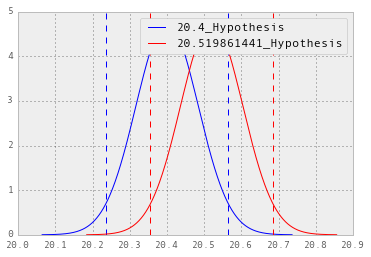

In [209]:
h1_rv, h0_l, h0_u = plot_hypothesis_distributions({mean_h0 : 'b', mean_h1:'r'}, se)

### Confidence intervals 
h0_l (lower)

h0_u (upper)

In [210]:
h0_l

20.235374223218717

In [211]:
h0_u

20.564625776781281

Compute the probability of a false negative (Type II Error) by using the upper/lower confidence interval (**Use cdf on the sampling distribution rv). Explain what a false negative is in the context of this problem.

In [212]:
beta = h1_rv.cdf(h0_u)
beta

0.702964175895195

In [213]:
power = 1 - beta
power

0.297035824104805

In [214]:
def plot_ci(m, se, c, ci=0.95):
    z = stats.norm.ppf(ci + (1 - ci) / 2)
    l_ci = m - z*se
    u_ci = m + z*se
    
    plt.axvline(x = l_ci, c=c, alpha=.9, linestyle=':')
    plt.axvline(x = u_ci, c=c, alpha=.9, linestyle=':')
    return l_ci, u_ci

(20.235374223218717, 20.564625776781281)

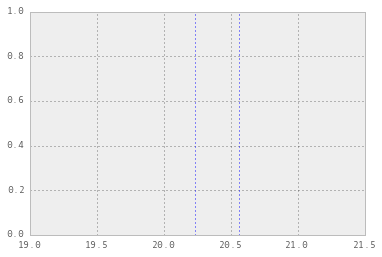

In [215]:
plot_ci(20.4, se, 'b')

- Based on the 95% CI we conclude that the weight of a bottle of coke on average is not different 
  from 20.4, i.e. we cannot reject the null that the weight is 20.4


____

Write a function explore_power that includes all the steps in Part 0. The input will be the mean value under the null hypothesis (i.e. 20.4 ounce as we have specified above) and the output is the power.

In [216]:
def explore_power(m_h0, darr, significance_level):
    m_h1 = darr.mean()
    se = darr.std() / float(sqrt(len(darr)))
    rv_h0 = stats.norm(m_h0, se)
    rv_h1 = stats.norm(m_h1, se) 
    h0_l = rv_h0.ppf(significance_level/2) # 0.025 : (significance_lev/2) Lower level 
    h0_u = rv_h0.ppf(1-significance_level/2) # 0.975 : (1 - significance_lev/2) Upper level : https://en.wikipedia.org/wiki/1.96
    beta = rv_h1.cdf(h0_u) - rv_h1.cdf(h0_l)
    power = 1 - beta
    return power
    

In [217]:
explore_power(20.4, darr, 0.05)

0.2973891529867565

Assume now the null hypothesis is that a bottle of coke weights 20.2 ounces. Run explore_power() with the new null hypothesis. Did the power increase or decrease? Explain your observation.

In [218]:
explore_power(20.2, darr, 0.05)

0.96771107839014836

In [219]:
darr_k = np.loadtxt('coke_weights_1000.txt')

In [220]:
explore_power(20.4, darr_k, 0.05)

0.72893273393690783

the power increased and because the power is the probabilidad of correctly reject the null hypothesis, and the beta value is the false negative rate. If we increase power we decrease beta, this mean that we reduce the probability of getting a type II error(false negative). When beta decrease it's harder to make a type II error.

---

(0, 1.1)

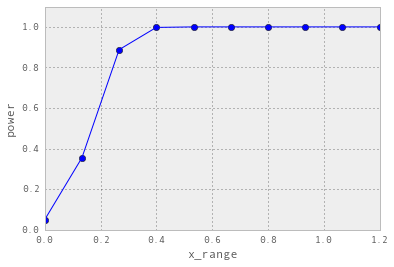

In [286]:
powers = []
x_range = np.linspace(0, 1.2, 10)
for m_h1 in (x_range + mean_h1):
    powers.append(explore_power(m_h1, darr, 0.05))
    
plt.plot(x_range, powers, 'bo', x_range, powers, 'b')
plt.xlabel('x_range')
plt.ylabel('power')
plt.ylim(0, 1.1)

(0, 1.1)

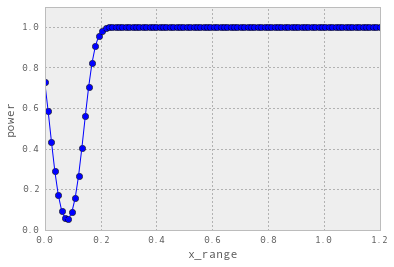

In [267]:
powers = []
x_range = np.linspace(0, 1.2, 100)
for m_h0 in (x_range + 20.4):
    powers.append(explore_power(m_h0, darr_k, 0.05))
    
plt.plot(x_range, powers, 'bo', x_range, powers, 'b')
plt.xlabel('x_range')
plt.ylabel('power')
plt.ylim(0, 1.1)

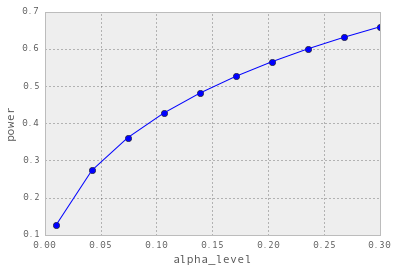

In [285]:
powers = []
alpha_level = np.linspace(0.01, 0.3, 10)
for alpha in alpha_level:
    powers.append(explore_power(20.4, darr, alpha))
    
plt.plot(alpha_level, powers, 'bo', alpha_level, powers, 'b')
plt.xlabel('alpha_level')
plt.ylabel('power')


One common problem in A/B testing is to decide when to stop the experiment. 

Power calculations are very useful in determining what required minimum sample size is necessary to reach a certain power (usually 80%) given an effect size and a significance level. 

A powerful test would ensure we are able to detect differences in conversion the majority of the time given the difference in fact exists. To gain insights about the effect size, a small-scale pilot experiment is usually launched. The minimum sample size is computed. Subsequently, a full-scale experiment is run until the minimum sample size is reached.



In [289]:
df = pd.read_csv('weeks_SHARED/W2_shared/power-bayesian/power-bayesian_du/data/experiment.csv')

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191148 entries, 0 to 191147
Data columns (total 5 columns):
user_id         191148 non-null int64
ts              191148 non-null float64
ab              191148 non-null object
landing_page    191148 non-null object
converted       191148 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.8+ MB


In [293]:
df.describe().T

count          mean           std         min           25%  \
user_id    191148  5.007786e+09  2.889032e+09        3416  2.505443e+09   
ts         191148  1.357042e+09  2.493174e+04  1356998400  1.357020e+09   
converted  191148  9.980225e-02  2.997369e-01           0  0.000000e+00   

                  50%           75%         max  
user_id    5005865728  7.508326e+09  9999962347  
ts         1357041629  1.357063e+09  1357084799  
converted           0  0.000000e+00           1

In [294]:
df[:2]

user_id          ts         ab landing_page  converted
0  4040615247  1356998400  treatment     new_page          0
1  4365389205  1356998400  treatment     new_page          0

In [295]:
df.landing_page.unique()

array(['new_page', 'old_page'], dtype=object)

In [307]:
old_page = df[df.landing_page == 'old_page']['converted']

In [308]:
new_page = df[df.landing_page == 'new_page']['converted']

Historically, the old page has a conversion of 10% and we wish to test if the new page provides a 0.1% increase (1% lift) in conversion. Recall the null and alternative hypotheses below:

Set X as a random variable which is the (new conversion - old conversion)\

X ~ p_new - p_old

H0: X = 0.001

H1: X > 0.001



Note: because I'm evaluating increase, one-tailed test is in order


### Computing Power for Pilot Sample

In this part, we are going to compute statistical power for the pilot experiment given the null hypothesis.

1. By CLT, we can approximate the sampling distribution of proportions (`p_new, p_old`) to be normal (since proportion is
   effectively a measure of mean). We can further assume the sampling distribution of `p_new - p_old` to be normal.

   Compute `p_new - p_old` and the standard error from the sample and define a normal distribution random variable. Plot
   the PDF of the random variable as you have done previously

   **Hint: Standard Error for difference of proportions**

   - `p` is a weighted average of the `p1` and `p2` ( p:conversion rate )
   - `n1` is the number of subjects sampled from the first population
   - `n2` is the number of subjects sampled from the second population



In [309]:
p_old = sum(old_page) / float(len(old_page))
p_new = sum(new_page) / float(len(new_page))

In [310]:
X = p_new - p_old
X

-0.0002406512231359903

In [312]:
conversion = (sum(new_page)+ sum(old_page)) / float(len(new_page) + len(old_page))
conversion

0.099802247473162159

In [314]:
variance = conversion * (1 - conversion)
variance

0.089841758872467856

In [317]:
se_ = np.sqrt(variance * (1. / len(new_page) + 1. / len(old_page)))
se_

0.0013711476995678985

Define another random variable for the null distribution and plot the PDF of the random variable. Add a vertical line on the plot to indicate the bound for rejecting the null hypothesis given a significance level of 5%

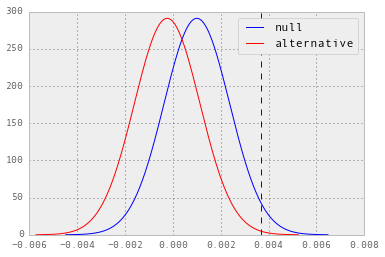

In [329]:
null_dist = stats.norm(0.001, se_)
null_x = np.linspace(0.001 - (4*se_), 0.001 + (4*se_), 1000)
null_y = null_dist.pdf(null_x)

plt.plot(null_x, null_y, c='b', label = 'null')


alternative_dist = stats.norm(X, se_)
alt_x = np.linspace(X - (4*se_), X + (4*se_), 1000)
alt_y = alternative_dist.pdf(alt_x)

plt.plot(alt_x, alt_y, c='r', label = 'alternative')
plt.legend(loc='upper right')

plt.axvline(null_dist.ppf(.975), ls='dashed')

In [331]:
# Standard Error for difference of proportions
null_upper = null_dist.ppf(.975)
beta = alternative_dist.cdf(null_upper)
power = 1 - beta
power

0.0020864240019986546

Assume after reviewing the data, Etsy decided the pilot is a plausible enough representation of the company's daily
   traffic. As a result, Esty decided on a two-tailed test instead, which is as follows:

   ```
   X ~ p_new - p_old

   H0: X = 0.001
   H1: X != 0.001
   ```

In [332]:
# Standard Error for difference of proportions
null_upper = null_dist.ppf(.025)
beta = alternative_dist.cdf(null_upper)
power = 1 - beta
power

0.85431869980442476


### Computing Minimum Sample Size

Assume Etsy is staying with the two-tailed test. A decision then would have to be
made about how long the test is running.

The minimum sample size is calculated by following the exact same process with calculating power, except power is a given (80%)
and sample size is omitted

1. Write a function `calc_min_sample_size` that would take
   - 2 lists/arrays of data (i.e. new page converts and old page converts)
   - Significance Level (Default: 0.05)
   - One-tailed to two-tailed test
   - Effect Size
   - Power (Default: 0.8)

   And return the minimum sample size required (rounded up to the nearest whole number).


In [337]:
def min_sample_size(arr1, arr2, alpha, power, effect_size, two_tailed=True):
    miu_1 = arr1.mean()
    miu_2 = arr2.mean()
    conversion = (sum(arr1) + sum(arr2)) / float(len(arr1) + len(arr2))
    variance = conversion * (1-conversion)
    se = np.sqrt(variance*(1./len(arr1) + 1./len(arr2)))
    distribution_1 = stats.norm(miu_1, se)
    distribution_2 = stats.norm(miu_2, se)
    z_power = distribution_2.ppf(power)
    if two_tailed:
        n = (2*variance) * (distribution_1.ppf(1 - alpha/2) + z_power)**2 / effect_size**2
    else:
        n = (2*variance) * (distribution_1.ppf(1 - alpha) + z_power)**2 / effect_size**2
    return n
    

In [338]:
min_sample_size(new_page, old_page, 0.05, 0.8, 0.001, False)

7405.5862508357823